In [3]:
%run '/home/ihs3/Documents/Notebooks/import_plots.ipynb'
%run '/home/ihs3/Documents/Notebooks/import_getters.ipynb'

In [4]:
import scipy as sp

In [5]:
def getSats(sensor, eventTupleList):
    ''' NAME
            getStats

        DESCRIPTION
            This function uses a list of eventTuples or single tuple and performs statistical analysis 
            on sensor data for each tuple to return a dataframe with mean, max, min, std, skew, kurtosis, 
            and tuple info.  

        INPUT
            sensor:           name of sensor to get data for
            eventTupleList:   can be either a list of eventTuples or a single tuple

        RETURN
            returns a dataframe containing statistical calculations for each event with an index of event ID, 
            reactor, and run

        EXAMPLE
            1.) Multiple Events
            #Get list of Argon events
            dataBase ='rct007'
            gasType ='Argon'
            gasEventsDf = getGasEvents(dataBase,gasType)

            #Get list of tuples for Argon events
            eventTupleList = gasEventsDf.index
            sensor = 'rct_rtd1'

            getStats(sensor, eventTupleList)

            2.) Single Event
            eventTuple = getEvents('rct007').index
            eventNumber = 3
            singleEvent = [eventTuple[eventNumber]]
            sensor = 'rct_rtd1'

            getStats(sensor, singleEvent)'''
    
    list1 = ['mean', 'max', 'min', 'std', 'skew', 'kurt']
    stats = pd.DataFrame(columns = list1)
    df = pd.DataFrame()
    for eventTup in eventTupleList:

        #Get data
        [datetime, data] = getEngData(sensor, eventTup)
        
        #Analyze data
        mean = data.mean()
        maxval = data.max()
        minval = data.min()
        std = data.std()   
        skew1 = sp.stats.skew(data)
        skew = skew1[0]
        kurtosis1 = sp.stats.kurtosis(data, fisher=False)
        kurtosis = kurtosis1[0]
        
        #Compile data
        A = [[mean], [maxval], [minval], [std], [skew], [kurtosis]]
        B = zip(*A)
        df1 = pd.DataFrame(B, columns = list1)        
        stats = pd.concat([stats, df1], axis=0)
    
    #Re-index dataframe with eventTuple info
    index = pd.MultiIndex.from_tuples(eventTupleList, names=['event id', 'reactor', 'run'])
    stats = stats.set_index(index)
    
    return stats

def findInputPower(eventTuple):
    
    ''' NAME
            findInputPower
        
        DESCRIPTION
            This function calculates the input power of the fan and reactor heaters
        
        INPUT
            eventTuple:  contains event ID, run, and database info
        
        RETURN
            returns a calculated value for input power
        
        EXAMPLE
            eventTuple = getEvents('rct007').index
            
            findInputPower(eventTuple[12])'''
    
    lineVoltageSensor = 'v5'
    fanCurrentSensor = 'v8'
    htr1CurrentSensor = 'v1'
    htr2CurrentSensor = 'v4'
    
    datetime, lineVoltage = getEngData(lineVoltageSensor, eventTuple)
    datetime, fanCurrent = getEngData(fanCurrentSensor, eventTuple)
    datetime, h1Current = getEngData(htr1CurrentSensor, eventTuple)
    datetime, h2Current = getEngData(htr2CurrentSensor, eventTuple)

    pwrFan =  lineVoltage * fanCurrent
    pwrHtr1 = lineVoltage * h1Current
    pwrHtr2 = lineVoltage * h2Current
    
    meanPwrFan = pwrFan.mean()
    stdPwrFan = pwrFan.std()
    meanPwrHtr1 = pwrHtr1.mean()
    stdPwrHtr1 = pwrHtr1.std()
    meanPwrHtr2 = pwrHtr2.mean()
    stdPwrHtr2 = pwrHtr2.std()
    
    meanPwr = meanPwrFan+meanPwrHtr1+meanPwrHtr2   
    
    return meanPwr

#For OutputPower function
def density(temp):
    Density = (1.626*(10**-5)*temp**3-6.021*(10**-3)*temp**2+0.021*temp + 1000.066)/1000
    return Density

#For OutputPower function
def specificHeat(temp):
    SH = -3.588*(10**-11)*(temp**5)+1.212*(10**-8)*(temp**4)-1.564*(10**-6)*(temp**3)+1.036*(10**-4)*(temp**2)-3.266*(10**-3)*temp + 4.216
    return SH

def findOutputPower(eventTuples, path = '/home/ihs3/Documents/Notebooks/Data/'):
    #read in flow data
    fi = getEngData('flowin', eventTuples)
    fit = getEngData('flowin_rtd', eventTuples)
    fo = getEngData('flowout', eventTuples)
    fot = getEngData('flowout_rtd', eventTuples)
    
    #temperatures
    fitmean = fit[1].mean()
    fotmean = fot[1].mean()
    fiotmean = (fitmean+fotmean)/2
    deltaT = fotmean-fitmean
    
    #Find how much data is is flowin & flowout - if len(fi[0]) = 3, means no data
    minimumValidData=240
    fil = len(fi[0])
    fol = len(fo[0])
    
    flag=True
    
    #If both are less than minimum; give nan 
    if fil<minimumValidData and fol<minimumValidData:
        Qout = np.nan
        return Qout, flag
    
    #If flowout has the minimum but flowin doesn't, then use flowout with flag (True when using flowout)
    if fil < minimumValidData:
        flag = False
        fi = fo
        
    dt = np.diff((fi[0]-fi[0][0]).total_seconds())
    dv = np.diff(fi[1].T)

    dt.reshape(1,len(dt))
    flowrate = dv/dt
    flowrate = flowrate[flowrate > 0]#gets rid of reset counter
    volumeFlowRate = np.mean(flowrate)#Liters per second
    Qout = volumeFlowRate*density(fiotmean)*specificHeat(fiotmean)*deltaT*1000
    
    return Qout, flag

from __future__ import division
def findOutputPowerTime(cursor, run, start, end):
    #Getting necessary data
    tbName1 = run+'_flowindata'
    tbName2 = run+'_flowoutdata'
    tbName3 = run+'_plcdata'

    fi = readDateTable(cursor, tbName1, start, end)
    fo = readDateTable(cursor, tbName2, start, end)
    Temps = readDateTable(cursor, tbName3, start, end)

    #Temperatures
    Temps = Temps.loc[:,['flowin_rtd','flowout_rtd']]
    fit = np.mean(Temps.iloc[:,0])
    fot = np.mean(Temps.iloc[:,1])
    dT = fot - fit
    fiot = (fit + fot) / 2

    #Flowin and flowout
    #Find how much data is is flowin & flowout - if len(fi[0]) = 3, means no data
    minimumValidData=1200
    fil = len(fi)
    fol = len(fo)

    #If both are less than minimum; give nan 
    if fil and fol <minimumValidData:
        Qout = np.nan
        return Qout

    #If flowout has the minimum but flowin doesn't, then use flowout with flag
    if fil < minimumValidData:
        fi = fo
        print "flowout date being used"

    for x in range(0,len(fi)-1):
        if fi.iloc[x,1]<fi.iloc[x-1,1]:
            time1 = (fi.iloc[x-1,0]-fi.iloc[0,0]).seconds
            time2 = (fi.iloc[-1,0]-fi.iloc[x,0]).seconds
            if time1>time2:
                volumeFlowRate = (fi.iloc[x-1,1]-fi.iloc[0,1])/time1/1860
            else:
                volumeFlowRate = (fi.iloc[-1,1]-fi.iloc[x,1])/time2/1860
        Qout = volumeFlowRate*density(fiot)*specificHeat(fiot)*dT*1000
          
    return Qout

def findInputPowerTime(cursor, run, start, end):
    tbName1 = run + '_voltagedata'
    
    voltages = readDateTable(cursor, tbName1, start, end)
    
    lineVoltage = voltages.loc[:, ['v5']]*23
    fanCurrent  = voltages.loc[:, ['v8']]*0.5
    h1Current   = voltages.loc[:, ['v1']]*0.5
    h2Current   = voltages.loc[:, ['v4']]*0.5

    pwrFan  = lineVoltage.values * fanCurrent.values
    pwrHtr1 = lineVoltage.values * h1Current.values
    pwrHtr2 = lineVoltage.values * h2Current.values

    meanPwrFan = pwrFan.mean()
    stdPwrFan = pwrFan.std()
    meanPwrHtr1 = pwrHtr1.mean()
    stdPwrHtr1 = pwrHtr1.std()
    meanPwrHtr2 = pwrHtr2.mean()
    stdPwrHtr2 = pwrHtr2.std()

    meanPwr = meanPwrFan + meanPwrHtr1 + meanPwrHtr2
    
    return meanPwr

def gasPlot(lowArrayIn, lowArrayOut, highArrayIn, highArrayOut, title):
    %matplotlib inline

    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)    


    sns.set_style("white")
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.scatter(lowArrayIn, (lowArrayOut), s = 30, color=tableau20[12], marker = "o", label = 'Low')
    ax.scatter(highArrayIn, (highArrayOut), s = 30, color=tableau20[14], marker = "s", label = 'High')
    plt.legend(loc = 'upper right')
    plt.xlim(0, 300)
    plt.ylim(0, 300)

    plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    sns.despine(trim=True, left=True, bottom=True)

    ax = sns.regplot(x=np.array(allPowerIn), y=np.array(allPowerOut), ci=99, line_kws={'lw': 2}, color=tableau20[4], scatter=False)

    plt.xlabel('\nPower In $(W)$', fontsize=18)
    plt.ylabel('\nPower Out $(W)$', fontsize=18)
    plt.title(title, fontsize = 20)

In [6]:
database = 'rct007'
run = '004'
eventsDf = getEvents(database)
eventTuple = eventsDf.index
sensor1 = ''
sensor2 = ''

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [7]:
eventsDf[-8:]

,,,Start_Time,Stop_Time,Duty_Cycle,Gas,Pressure
eventId,dataBase,run,,,,,
132,rct007,004,2016-07-23 08:58:55.214170,2016-07-23 09:28:57.534046,0,Deuterium,15
133,rct007,004,2016-07-26 21:12:32.935434,2016-07-26 21:42:35.168807,0,Helium,13.2
134,rct007,004,2016-07-26 23:12:42.038858,2016-07-26 23:42:44.214358,0.05,Helium,13.2
135,rct007,004,2016-07-27 01:12:51.037202,2016-07-27 01:42:53.190184,0.1,Helium,13.2
136,rct007,004,2016-07-27 03:23:00.175777,2016-07-27 03:53:02.216298,0.2,Helium,13.2
137,rct007,004,2016-07-27 05:43:09.944541,2016-07-27 06:13:12.267361,0.4,Helium,13.2
138,rct007,004,2016-07-27 08:13:21.268337,2016-07-27 08:43:23.516961,0.6,Helium,13.2
139,rct007,004,2016-07-27 11:13:34.629619,2016-07-27 11:43:36.763892,0,Helium,13.2


In [23]:
eventTuple = eventsDf[:8].index

In [9]:
for eventTup in eventTuple:
    a = findInputPower(eventTup)
    b = findOutputPower(eventTup)
    print a, b

10.1850808767 (24.11878781691998, True)
9.29285265832 (21.18836491780332, True)
29.8047803545 (40.100638997986252, True)
49.3958538061 (59.294329109458531, True)
88.2783000763 (97.752664948019884, True)
159.901573635 (170.15493260989004, True)
238.106661297 (235.2932235867984, True)
10.1590142316 (23.626700460739038, True)


In [15]:
eventsDf

,,,Start_Time,Stop_Time,Duty_Cycle,Gas,Pressure
eventId,dataBase,run,,,,,
0,rct007,004,2016-06-28 00:46:39.381692,2016-06-28 01:16:41.334500,0,Vacuum,0.000028
1,rct007,004,2016-06-28 02:46:47.820485,2016-06-28 03:16:49.830191,0.05,Vacuum,0.000028
2,rct007,004,2016-06-28 04:46:56.306332,2016-06-28 05:16:58.364696,0.1,Vacuum,0.000028
3,rct007,004,2016-06-28 07:07:06.402626,2016-06-28 07:37:08.680572,0.2,Vacuum,0.000028
4,rct007,004,2016-06-28 09:17:15.895275,2016-06-28 09:47:17.810393,0.4,Vacuum,0.000028
5,rct007,004,2016-06-28 11:57:27.140698,2016-06-28 12:27:29.471676,0.6,Vacuum,0.000028
6,rct007,004,2016-06-28 15:07:41.222185,2016-06-28 15:37:43.563907,0,Vacuum,0.000028
7,rct007,004,2016-06-28 15:50:06.504234,2016-06-28 16:20:08.797504,0,Vacuum,0.000042
8,rct007,004,2016-06-28 17:50:15.421791,2016-06-28 18:20:17.367728,0.05,Vacuum,0.000042


## Loop through all events for Power In and Power Out

In [25]:
powerIn = ([])
powerOut = ([])
eventTupleList = ([])

for eventTup in eventTuple:

    powerIn.append(findInputPower(eventTup))
    powerOut.append(findOutputPower(eventTup)[0])
    eventTupleList.append(eventTup)

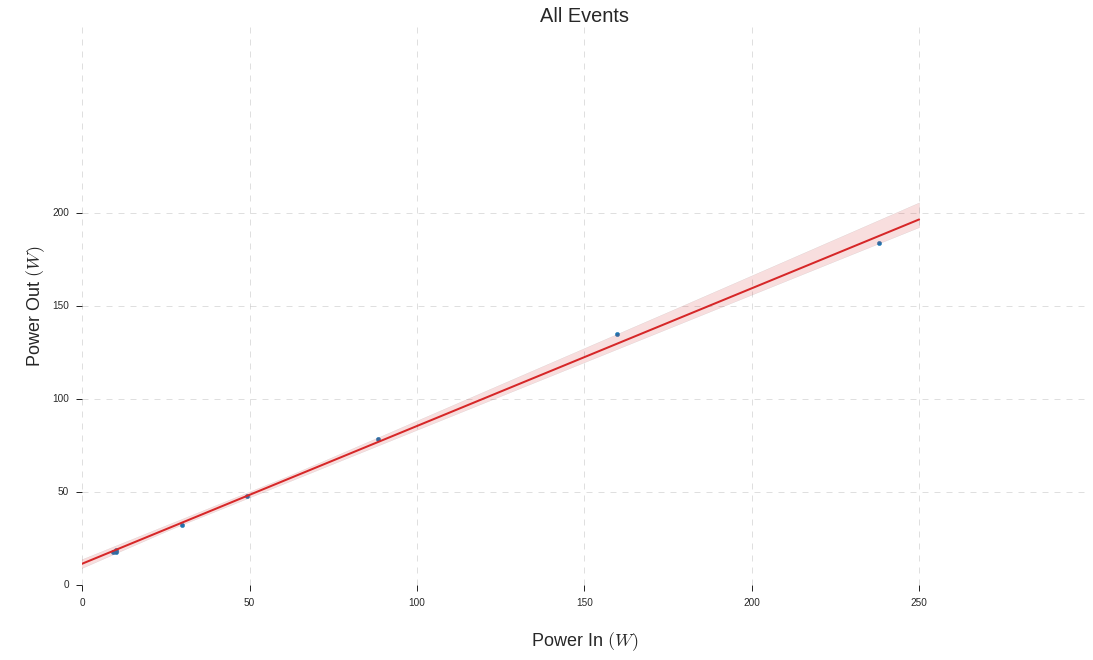

In [15]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(powerIn, (powerOut), color=tableau20[0])

plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
ax = sns.regplot(x=np.array(powerIn), y=np.array(powerOut), ci=99, line_kws={'lw': 2}, color=tableau20[6], scatter=False)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)
plt.title('All Events', fontsize = 20)


## Loop through gas types separately for Power In and Power Out

In [12]:
gasType1 = 'Argon'
gasEvents1 = getGasEvents(database, gasType1)
argonEventTupleList = gasEvents1.index

gasType2 = 'Helium'
gasEvents2 = getGasEvents(database, gasType2)
heliumEventTupleList = gasEvents2.index

gasType3 = 'Hydrogen'
gasEvents3 = getGasEvents(database, gasType3)
hydrogenEventTupleList = gasEvents3.index

gasType4 = 'Deuterium'
gasEvents4 = getGasEvents(database, gasType4)
deuteriumEventTupleList = gasEvents4.index

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [13]:
gasEvents1_2 = gasEvents1.loc[gasEvents1['Pressure'] == '2']
gasEvents1_15 = gasEvents1.loc[gasEvents1['Pressure'] == '15']
gasEvents2_2 = gasEvents2.loc[gasEvents2['Pressure'] == '2']
gasEvents2_15 = gasEvents2.loc[gasEvents2['Pressure'] == '15']
gasEvents2_15.append(gasEvents2.loc[gasEvents2['Pressure'] == '15.3193'])
gasEvents3_2 = gasEvents3.loc[gasEvents3['Pressure'] == '2']
gasEvents3_15 = gasEvents3.loc[gasEvents3['Pressure'] == '15']
gasEvents4_2 = gasEvents4.loc[gasEvents4['Pressure'] == '2']
gasEvents4_15 = gasEvents4.loc[gasEvents4['Pressure'] == '15']

argonLowList = gasEvents1_2.index
argonHighList = gasEvents1_15.index
heliumLowList = gasEvents2_2.index
heliumHighList = gasEvents2_15.index
hydrogenLowList = gasEvents3_2.index
hydrogenHighList = gasEvents3_15.index
deuteriumLowList = gasEvents4_2.index
deuteriumHighList = gasEvents4_15.index

In [16]:
argonLowPowerIn = ([])
argonLowPowerOut = ([])
argonLowPressure = ([])
heliumLowPowerIn = ([])
heliumLowPowerOut = ([])
heliumLowPressure = ([])
hydrogenLowPowerIn = ([])
hydrogenLowPowerOut = ([])
hydrogenLowPressure = ([])
deuteriumLowPowerIn = ([])
deuteriumLowPowerOut = ([])
deuteriumLowPressure = ([])

argonHighPowerIn = ([])
argonHighPowerOut = ([])
argonHighPressure = ([])
heliumHighPowerIn = ([])
heliumHighPowerOut = ([])
heliumHighPressure = ([])
hydrogenHighPowerIn = ([])
hydrogenHighPowerOut = ([])
hydrogenHighPressure = ([])
deuteriumHighPowerIn = ([])
deuteriumHighPowerOut = ([])
deuteriumHighPressure = ([])

lowP = 2
highP = 15

for eventTup in argonLowList:

    argonLowPowerIn.append(findInputPower(eventTup))
    argonLowPowerOut.append(findOutputPower(eventTup)[0])
    argonLowPressure.append(lowP)
    
for eventTup in argonHighList:

    argonHighPowerIn.append(findInputPower(eventTup))
    argonHighPowerOut.append(findOutputPower(eventTup)[0])
    argonHighPressure.append(highP)

for eventTup in heliumLowList:

    heliumLowPowerIn.append(findInputPower(eventTup))
    heliumLowPowerOut.append(findOutputPower(eventTup)[0])
    heliumLowPressure.append(lowP)
    
for eventTup in heliumHighList:

    heliumHighPowerIn.append(findInputPower(eventTup))
    heliumHighPowerOut.append(findOutputPower(eventTup)[0])
    heliumHighPressure.append(highP)
    
for eventTup in hydrogenLowList:

    hydrogenLowPowerIn.append(findInputPower(eventTup))
    hydrogenLowPowerOut.append(findOutputPower(eventTup)[0])
    hydrogenLowPressure.append(lowP)

for eventTup in hydrogenHighList:

    hydrogenHighPowerIn.append(findInputPower(eventTup))
    hydrogenHighPowerOut.append(findOutputPower(eventTup)[0])
    hydrogenHighPressure.append(highP)

for eventTup in deuteriumLowList:

    deuteriumLowPowerIn.append(findInputPower(eventTup))
    deuteriumLowPowerOut.append(findOutputPower(eventTup)[0])
    deuteriumLowPressure.append(lowP)

for eventTup in deuteriumHighList:

    deuteriumHighPowerIn.append(findInputPower(eventTup))
    deuteriumHighPowerOut.append(findOutputPower(eventTup)[0])
    deuteriumHighPressure.append(highP)


In [17]:
allPowerIn = np.concatenate((argonLowPowerIn, argonHighPowerIn, heliumLowPowerIn, heliumHighPowerIn, hydrogenLowPowerIn, hydrogenHighPowerIn, deuteriumLowPowerIn, deuteriumHighPowerIn))
allPowerOut = np.concatenate((argonLowPowerOut, argonHighPowerOut, heliumLowPowerOut, heliumHighPowerOut, hydrogenLowPowerOut, hydrogenHighPowerOut, deuteriumLowPowerOut, deuteriumHighPowerOut))

## Power Variation by Duty Cycle

In [18]:
dutyCycle0 = getDutyCycleEvents(database, '0')
dutyCycle05 = getDutyCycleEvents(database, '0.05')
dutyCycle1 = getDutyCycleEvents(database, '0.1')
dutyCycle2 = getDutyCycleEvents(database, '0.2')
dutyCycle4 = getDutyCycleEvents(database, '0.4')
dutyCycle6 = getDutyCycleEvents(database, '0.6')

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [95]:
# dutyCycle0 = dutyCycle0.ix[4:-2]
# dutyCycle05 = dutyCycle05.ix[2:-1]
# dutyCycle1 = dutyCycle1.ix[2:-1]
# dutyCycle2 = dutyCycle2.ix[2:-1]
# dutyCycle4 = dutyCycle4.ix[2:-1]
# dutyCycle6 = dutyCycle6.ix[2:-1]

In [19]:
dutyCycle0List = dutyCycle0.index
dutyCycle05List = dutyCycle05.index
dutyCycle1List = dutyCycle1.index
dutyCycle2List = dutyCycle2.index
dutyCycle4List = dutyCycle4.index
dutyCycle6List = dutyCycle6.index

In [20]:
cyclePowerIn0 = ([])
cyclePowerOut0 = ([])
cyclePowerIn05 = ([])
cyclePowerOut05 = ([])
cyclePowerIn1 = ([])
cyclePowerOut1 = ([])
cyclePowerIn2 = ([])
cyclePowerOut2 = ([])
cyclePowerIn4 = ([])
cyclePowerOut4 = ([])
cyclePowerIn6 = ([])
cyclePowerOut6 = ([])

for eventTup in dutyCycle0List:

    cyclePowerIn0.append(findInputPower(eventTup))
    cyclePowerOut0.append(findOutputPower(eventTup)[0])

for eventTup in dutyCycle05List:

    cyclePowerIn05.append(findInputPower(eventTup))
    cyclePowerOut05.append(findOutputPower(eventTup)[0])
    
for eventTup in dutyCycle1List:

    cyclePowerIn1.append(findInputPower(eventTup))
    cyclePowerOut1.append(findOutputPower(eventTup)[0])
    
for eventTup in dutyCycle2List:

    cyclePowerIn2.append(findInputPower(eventTup))
    cyclePowerOut2.append(findOutputPower(eventTup)[0])
    
for eventTup in dutyCycle4List:

    cyclePowerIn4.append(findInputPower(eventTup))
    cyclePowerOut4.append(findOutputPower(eventTup)[0])
    
for eventTup in dutyCycle6List:

    cyclePowerIn6.append(findInputPower(eventTup))
    cyclePowerOut6.append(findOutputPower(eventTup)[0])


### To get stats on duty cycle powers, NaN's must be filtered out

In [21]:
cyclePowerIn0 = filter(lambda v: v==v, cyclePowerIn0)
cyclePowerOut0 = filter(lambda v: v==v, cyclePowerOut0)

In [66]:
np.mean(cyclePowerIn0)

10.198707468241569

In [67]:
np.mean(cyclePowerOut0)

24.464545543904524

## Argon Low/High

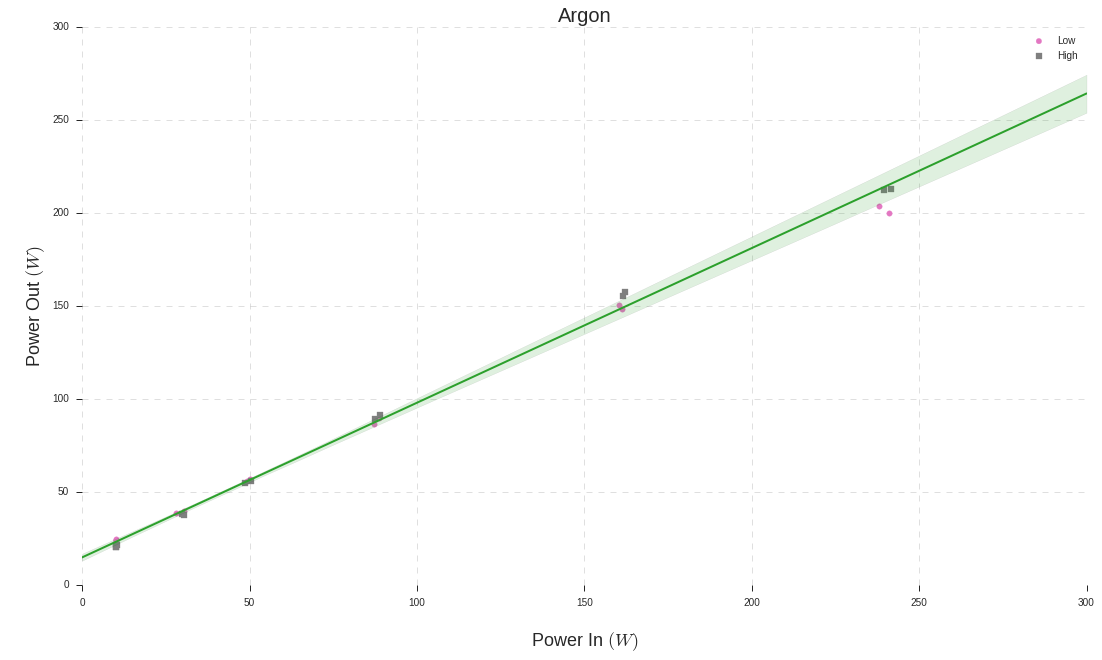

In [22]:
gasPlot(argonLowPowerIn, argonLowPowerOut, argonHighPowerIn, argonHighPowerOut, 'Argon')

## Helium Low/High

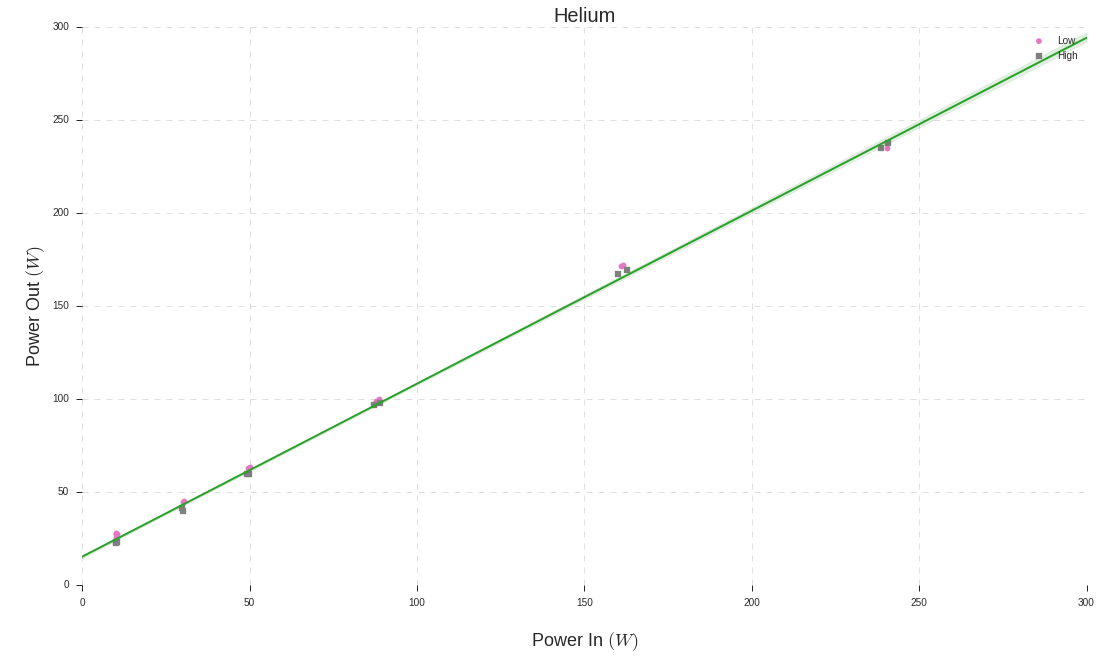

In [52]:
gasPlot(heliumLowPowerIn, heliumLowPowerOut, heliumHighPowerIn, heliumHighPowerOut, 'Helium')

## Hydrogen Low/High

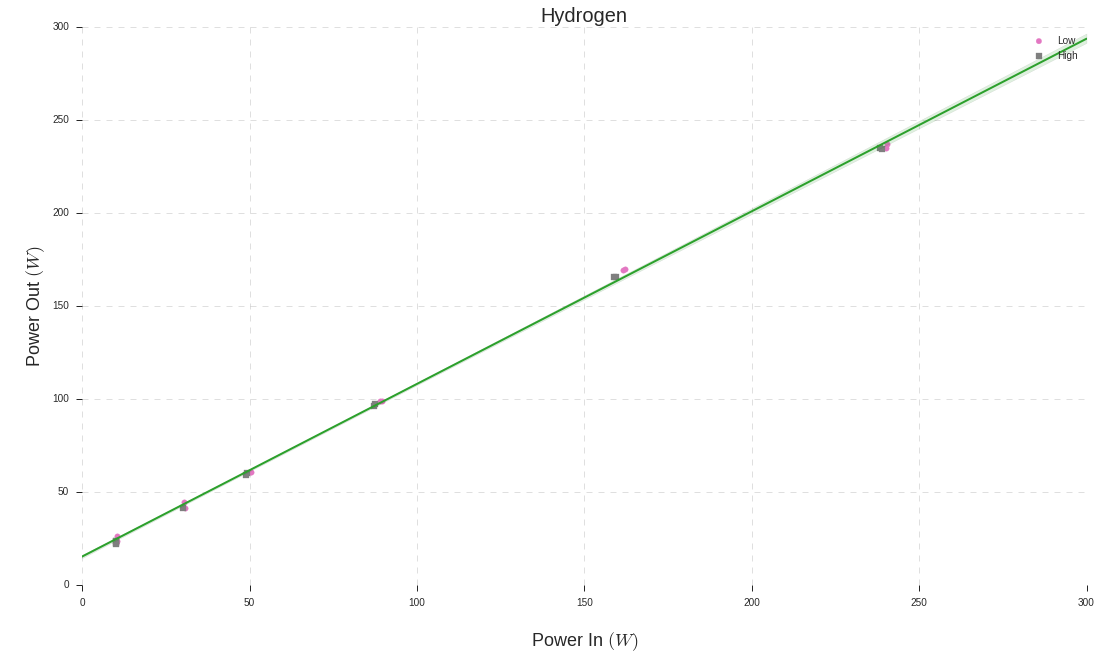

In [34]:
gasPlot(hydrogenLowPowerIn, hydrogenLowPowerOut, hydrogenHighPowerIn, hydrogenHighPowerOut, 'Hydrogen')

## Deuterium Low/High

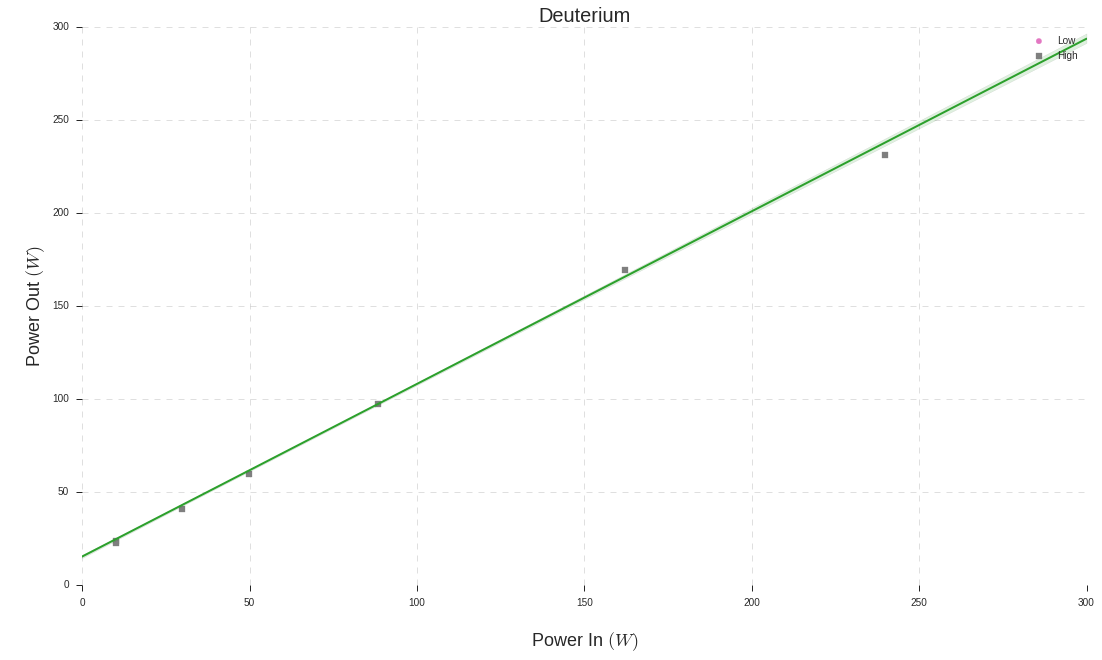

In [35]:
gasPlot(deuteriumLowPowerIn, deuteriumLowPowerOut, deuteriumHighPowerIn, deuteriumHighPowerOut, 'Deuterium')

## All Gases

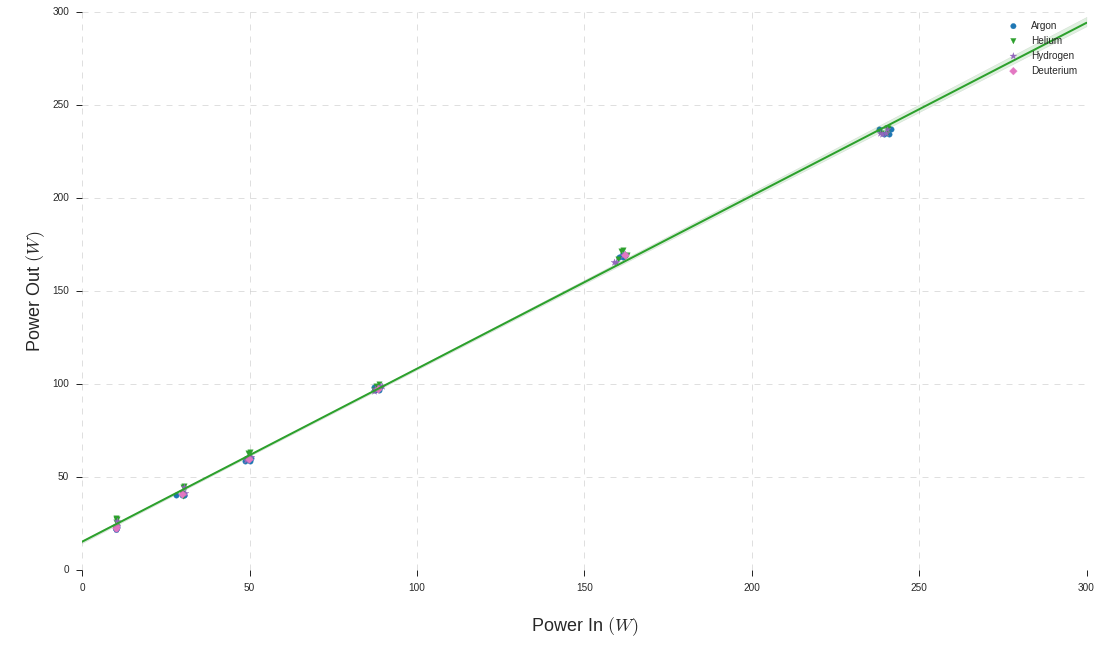

In [53]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(argonLowPowerIn, (argonHighPowerOut), s = 30, color=tableau20[0], marker = "o", label = 'Argon')
ax.scatter(argonHighPowerIn, (argonHighPowerOut), s = 30, color=tableau20[0], marker = "o")
ax.scatter(heliumLowPowerIn, (heliumLowPowerOut), s = 30, color=tableau20[4], marker = "v", label = 'Helium')
ax.scatter(heliumHighPowerIn, (heliumHighPowerOut), s = 30, color=tableau20[4], marker = "v")
ax.scatter(hydrogenLowPowerIn, (hydrogenLowPowerOut), s = 50, color=tableau20[8], marker = "*", label = 'Hydrogen')
ax.scatter(hydrogenHighPowerIn, (hydrogenHighPowerOut), s = 50, color=tableau20[8], marker = "*")
ax.scatter(deuteriumLowPowerIn, (deuteriumLowPowerOut), s = 30, color=tableau20[12], marker = "D", label = 'Deuterium')
ax.scatter(deuteriumHighPowerIn, (deuteriumHighPowerOut), s = 30, color=tableau20[12], marker = "D")
plt.legend(loc = 'upper right')
plt.xlim(0, 300)
plt.ylim(0, 300)

plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)

ax = sns.regplot(x=np.array(allPowerIn), y=np.array(allPowerOut), ci=99, line_kws={'lw': 2}, color=tableau20[4], scatter=False)

plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)




In [25]:
startTime = '2016-07-15 15:22:00.000000'
endTime   = '2016-07-15 15:27:00.000000'
        
[plcDf, logDf, flowInDf, flowOutDf, voltageDf] = timeQuery(database, run, startTime, endTime)

In [17]:
voltageDf['Voltage'] = voltageDf['v6']*200
voltageDf['Current'] = voltageDf['v3']*.020
voltageDf['Power'] = voltageDf['Voltage']*voltageDf['Current']

In [19]:
voltageDf.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,Voltage,Current,Power
count,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000,135184.000000
mean,0.000120,-0.017171,-0.710347,0.000031,0.001284,-1.820805,0.000077,0.000145,-364.161062,-0.014207,9.979394
std,0.004555,0.000242,0.780118,0.004551,5.250734,1.604145,0.000220,0.234517,320.829003,0.015602,11.046882
min,-0.016200,-0.019200,-2.031000,-0.015900,-7.421700,-3.593500,-0.000900,-0.390300,-718.700000,-0.040620,-0.066612
25%,-0.004000,-0.017400,-1.281100,-0.004300,-5.347475,-3.541900,0.000000,-0.198700,-708.380000,-0.025622,0.000721
50%,0.000000,-0.017100,-0.005500,0.000000,-0.000900,-0.302100,0.000000,0.000300,-60.420000,-0.000110,0.006574
75%,0.004300,-0.017100,-0.000600,0.004300,5.349200,-0.300900,0.000300,0.199000,-60.180000,-0.000012,18.145862
max,0.015600,-0.015900,0.048200,0.015900,7.351200,-0.257900,0.001200,0.371100,-51.580000,0.000964,28.781707


In [23]:
pwd

u'/home/ihs3/Documents/Notebooks'